# Data setup 

## Import necessary packages

In [2]:
import texttable as tt
import matplotlib.pyplot as plt

import numpy as np

from sklearn.decomposition import PCA
from sklearn import preprocessing

from scipy.interpolate import interp1d
from scipy import interpolate
import itertools

## Initialize data from file

In [3]:
# initialize data 

def data_from_file(file_name):
    data = np.loadtxt(file_name)
    ids = data[0, :]    
    Flux = data[1:, :]
    iqs = list(range(180, -1, -10))
    xLabel = 'd-axis current - Id [A]'
    yLabel = 'Direct flux linkage [Wb]'
    Is = 'Iq '
    return ids, Flux, iqs, Is, xLabel, yLabel


ids, Flux, iqs, Is, xLabel, yLabel = data_from_file('PMaSynRM_input_data.txt')

print('iqs', iqs)
print('ids', ids)
print('dfs', Flux.shape)

iqs [180, 170, 160, 150, 140, 130, 120, 110, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
ids [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180.]
dfs (19, 19)


# [REDUCE POINTS]  
## DESCRIPTION reduce the number of d-axis Currents
## ORIGINAL PLOT
### A sample = Flux Linkage measured across different values of d-axis Currents

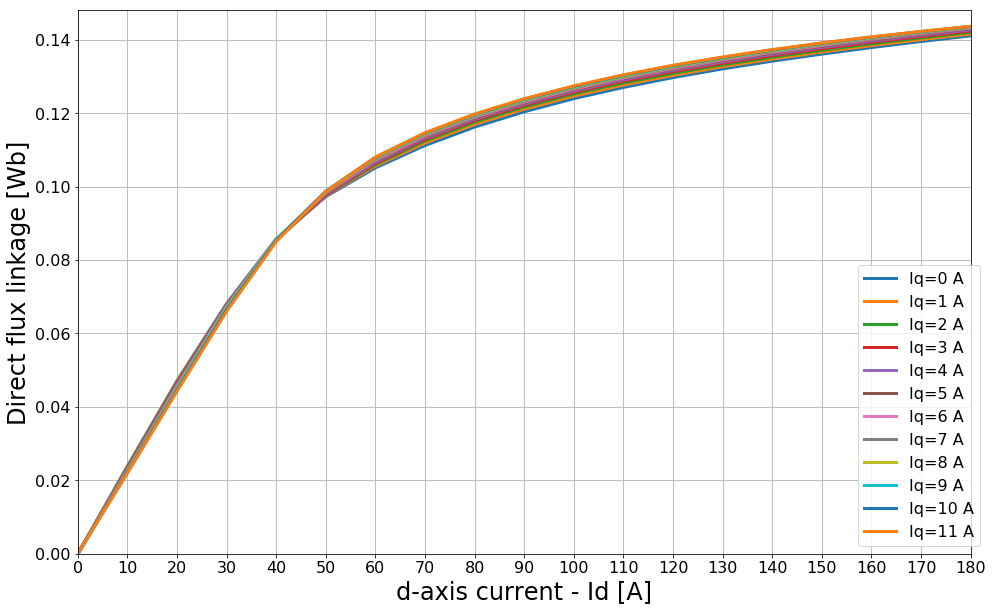

In [4]:
flux = np.copy(Flux)
plt.figure(figsize=[16,10])

curves_to_plot = list(range(12))
for idx in curves_to_plot:
    df =flux[:,idx]
    plt.plot(ids, df, linewidth=3, label= 'Iq=%d A' %(idx))
#     plt.scatter(ids,df, linewidths=4)
    plt.ylim([0,0.148])
    plt.xlim([0, 3])
    plt.xticks(ids, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel(xLabel, fontsize = 24)
    plt.ylabel(yLabel, fontsize = 24)
#     plt.title('Flux measured at different q-axis currents across multiple d-axis currents', fontsize=48)
    plt.legend(bbox_to_anchor=(1.02, 0), loc='lower right', ncol=1, fontsize=16)
plt.grid()
plt.show()

# [REDUCE Points] 
## Plot the PCA reconstruction error

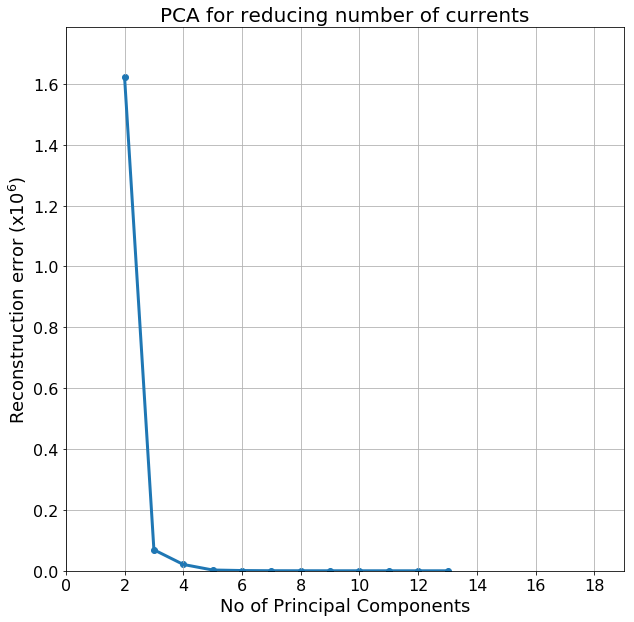

In [5]:

#preprocess the data
X = np.copy(Flux)
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(X)
no_of_comps = range(2, 14)

errors = []
for comp in no_of_comps:
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    errors.append(np.sum((projected_unscaled - X) ** 2))
# print('components shape: ', pca_reduce_points.components_.shape)

errors_readable = errors_readable = np.multiply (errors, 10**5)

plt.figure(figsize=(10, 10))
plt.xlabel('No of Principal Components', fontsize = 18)
plt.ylabel('Reconstruction error (x$10^6$)', fontsize = 18)
plt.xlim([0,19])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim([0.1*min(errors_readable), 1.1*max(errors_readable)])
plt.locator_params(axis='x', nbins=len(no_of_comps))
plt.scatter(no_of_comps, errors_readable)
plt.plot(no_of_comps, errors_readable, linewidth=3)
plt.grid()
plt.title('PCA for reducing number of currents', fontsize=20)
plt.show()



# [REDUCE Points]
## Find d-axis Currents with highest variance and choose top n


In [6]:

X = np.copy(Flux)
variance = np.var(X, axis=0)

currents_variance = sorted(zip(ids, variance), key=lambda e : e[1], reverse=True)
border_currents = [e for e in currents_variance if e[0] == min(ids)] + [e for e in currents_variance if e[0] == max(ids)]
non_border_currents = [e for e in currents_variance if e not in border_currents]

def get_top_ids_currents(currents_no):
    assert(currents_no >= 2)
    top_ids_currents = border_currents + non_border_currents[:currents_no-2]
    return sorted([e[0] for e in top_ids_currents])

top_n = range(2, 7)

print('Ids Currents with highest variance')
for n in top_n:
    top_n_curents = get_top_ids_currents(n)
    print('top %2d Id Currents' % n, top_n_curents)


Ids Currents with highest variance
top  2 Id Currents [0.0, 180.0]
top  3 Id Currents [0.0, 150.0, 180.0]
top  4 Id Currents [0.0, 150.0, 160.0, 180.0]
top  5 Id Currents [0.0, 140.0, 150.0, 160.0, 180.0]
top  6 Id Currents [0.0, 140.0, 150.0, 160.0, 170.0, 180.0]


# [REDUCE Points]  

-  We measure the flux value in key top n d-axis currents 
- then use  INTERPOLATION to predict flux across all d-axis currents 

- plot Interpolation error as a function of the number of points used as basis per each curve
- we expect to get the same shape like in PCA reconstruction (the previous plot)

Compare Interpolation With Different Number of Basis POINTS


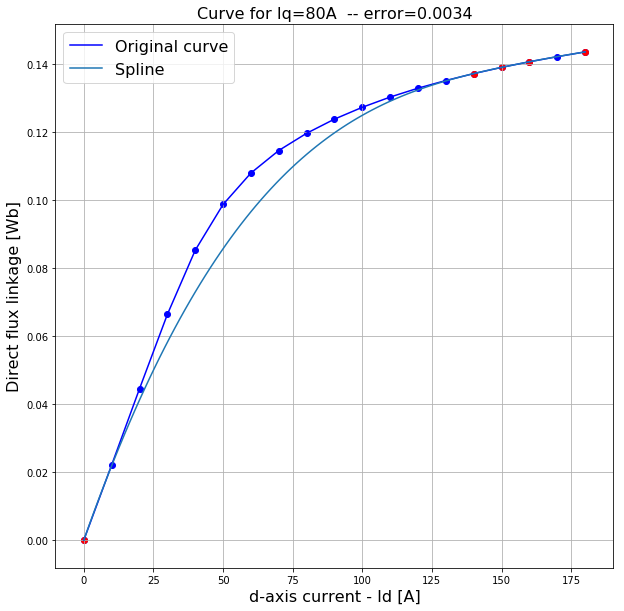

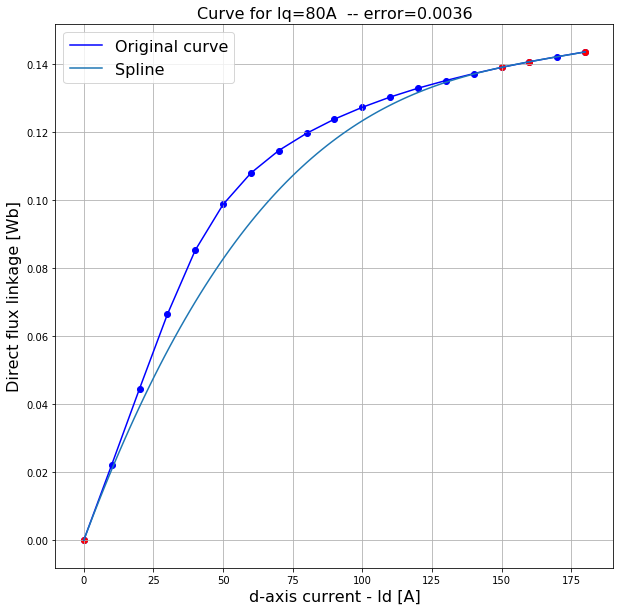

In [8]:
X = np.copy((Flux))
variance = np.var(X, axis=0)

# auxiliary function to determine the indexes in the dataset for certain Currents
def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (1) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

Id_currents_variance = sorted(zip(ids, variance), key=lambda e : e[1], reverse=True)
border_Id_currents = [e for e in Id_currents_variance if e[0] == min(iqs)] + [e for e in Id_currents_variance if e[0] == max(iqs)]
non_border_Id_currents = [e for e in Id_currents_variance if e not in border_Id_currents]

def get_top_ids_currents(currents_no):
    assert(currents_no >= 2)
    top_ids_currents = border_Id_currents + non_border_Id_currents[:currents_no-2]
    return sorted([e[0] for e in top_ids_currents])
    
def compare_curve_with_interp(curve, n, top_n_function, title):
    top_n_ids = top_n_function(n)
    top_n_ids_indices = [get_index(ids, c) for c in top_n_ids]
    plt.figure(figsize=(10, 10))
    
    x = np.array(ids)
    baseline = X[:,curve] 
      
    x_ = top_n_ids
    y_ = X[top_n_ids_indices,curve]
    
    ##learn the spline coeficients for 3 points
    splines = interpolate.splrep(x_,y_,s=0,k=3) 
    x_new = np.linspace(min(ids), max(ids),100)
    #create the spline for the newly created points x_new, using the top_n_ids
    y_new = interpolate.splev(x_new, splines, der = 0)     
    
    
    plt.plot(x, baseline, c='b', label = 'Original curve')
    plt.scatter(x, baseline, c='b')
    plt.plot(x_new, y_new, label = 'Spline')
   
    plt.scatter( x_,y_, c= 'r')
    error = sum_squared_error(baseline,y_new[len(ids)])
  
       
    plt.grid()   
    plt.title('%s -- error=%.4f' % (title, error), fontsize=16)
    plt.legend(loc='best', fontsize = 16)
    plt.xlabel(xLabel,fontsize = 16)
    plt.ylabel(yLabel,fontsize = 16)
    plt.show()
    

print('Compare Interpolation With Different Number of Basis POINTS')

curve = 10
n = 5
compare_curve_with_interp(curve, n, get_top_ids_currents, 'Curve for Iq=%dA ' % iqs[curve])

curve = 10
n = 4
compare_curve_with_interp(curve, n, get_top_ids_currents, 'Curve for Iq=%dA ' % iqs[curve])

# [REDUCE POINTS] 
## Plot the Interpolation Recontruction Error

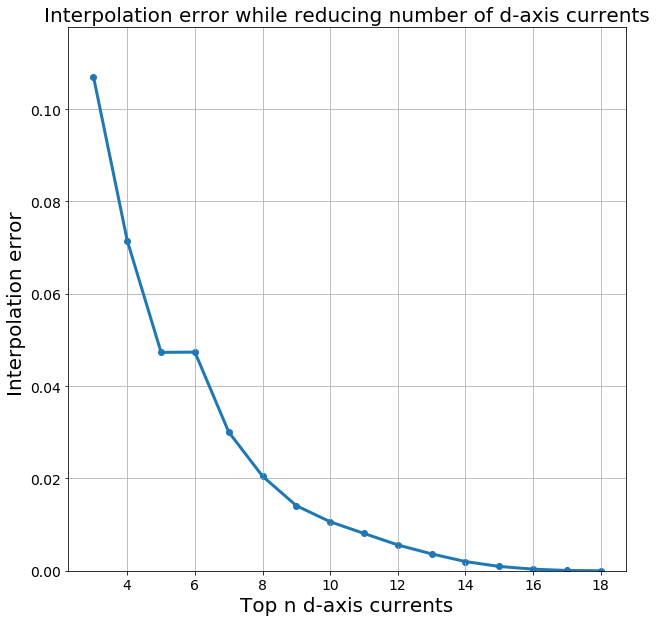

In [10]:

X = np.copy(Flux)
# print(X.shape)


top_n = range(3, len(ids))
errors = []
for n in top_n:
    top_n_id_currents = get_top_ids_currents(n)
    top_n_id_currents_indices = [get_index(ids, c) for c in top_n_id_currents]
    error = 0
    for curve in range(X.shape[0]):
        # baseline = y values obtained when interpolating with all ground truth points
        x = ids 
        baseline = X[curve, :] 

        # interpolate with top_n_currents as basis points
        x_ = top_n_id_currents
        y_ = X[curve, top_n_id_currents_indices]
        tck_ = interpolate.splrep(x_, y_, k=2)
        y = interpolate.splev(x, tck_) 
        
        # error -- difference between baseline interpolation curve and current one
        error += np.sum((baseline - y)**2) /  baseline.shape[0]
    errors.append(error / X.shape[0])
            
error_readable = np.multiply(errors, 10 **6)
        
plt.figure(figsize=(10, 10))
plt.xlabel('Top n d-axis currents', fontsize = 20)
plt.ylabel('Interpolation error ', fontsize = 20)
plt.ylim([0.1*min(error_readable), 1.1*max(error_readable)])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.locator_params(axis='x', nbins=len(top_n))
plt.scatter(top_n, error_readable)
plt.plot(top_n, error_readable, linewidth=3)
plt.grid()
plt.title('Interpolation error while reducing number of d-axis currents', fontsize=20)
plt.show()


# [REDUCE Curves] 
## DESCRIPTION reduce the number of q-axis Currents

- observed variable: flux at a specific q-axis  current value

- sample: given a current, measure flux value at different iqs; we are oblivious of the q-axis current under which the measurement was made; this descripition indicates only how all the samples were collected

- X.shape: (d-axis, q-axis)

- what we want: determine iqs with highest variance (this what PCA does) across all d-axis currents



# [REDUCE CURVES] 
## Plot PCA reconstruction error

components shape:  (13, 19)


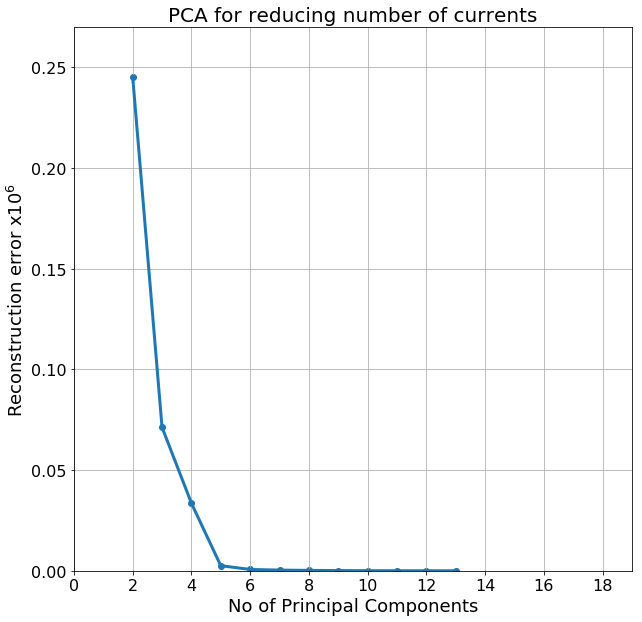

In [11]:

#preprocess the data
X = np.copy(np.transpose(Flux))
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(X)
no_of_comps = range(2, 14)

errors = []
for comp in no_of_comps:
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    errors.append(np.sum((projected_unscaled - X) ** 2))
print('components shape: ', pca_reduce_points.components_.shape)

errors_readable = errors_readable = np.multiply (errors, 10**5)

plt.figure(figsize=(10, 10))
plt.xlabel('No of Principal Components', fontsize = 18)
plt.ylabel('Reconstruction error x$10^6$', fontsize = 18)
plt.xlim([0,19])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim([0.1*min(errors_readable), 1.1*max(errors_readable)])
plt.locator_params(axis='x', nbins=len(no_of_comps))
plt.scatter(no_of_comps, errors_readable)
plt.plot(no_of_comps, errors_readable, linewidth=3)
plt.grid()
plt.title('PCA for reducing number of currents', fontsize=20)
plt.show()



# [REDUCE CURVES] HIGHEST VARIANCE Q-AXIS CURRENTS

In [12]:
X = np.transpose(np.copy(Flux))
variance = np.var(X, axis=0)

# auxiliary function to determine the indexes in the dataset for certain Q-axis Currents
def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

Iq_currents_variance = sorted(zip(iqs, variance), key=lambda e : e[1], reverse=True)
border_Iq_currents = [e for e in Iq_currents_variance if e[0] == min(iqs)] + [e for e in Iq_currents_variance if e[0] == max(iqs)]
non_border_Iq_currents = [e for e in Iq_currents_variance if e not in border_Iq_currents]

def get_top_iqs_currents(currents_no):
    assert(currents_no >= 2)
    top_Iq_currents = border_Iq_currents + non_border_Iq_currents[:currents_no-2]
    return sorted([e[0] for e in top_Iq_currents])

top_n = range(2, len(iqs))

print('Iq Currents with highest variance')
for n in top_n:
    top_n_Iq_currents = get_top_iqs_currents(n)
    print('top %2d Iq Currents' % n, top_n_Iq_currents)

Iq Currents with highest variance
top  2 Iq Currents [0, 180]
top  3 Iq Currents [0, 150, 180]
top  4 Iq Currents [0, 150, 160, 180]
top  5 Iq Currents [0, 140, 150, 160, 180]
top  6 Iq Currents [0, 110, 140, 150, 160, 180]
top  7 Iq Currents [0, 100, 110, 140, 150, 160, 180]
top  8 Iq Currents [0, 90, 100, 110, 140, 150, 160, 180]
top  9 Iq Currents [0, 90, 100, 110, 120, 140, 150, 160, 180]
top 10 Iq Currents [0, 90, 100, 110, 120, 130, 140, 150, 160, 180]
top 11 Iq Currents [0, 80, 90, 100, 110, 120, 130, 140, 150, 160, 180]
top 12 Iq Currents [0, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 180]
top 13 Iq Currents [0, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 180]
top 14 Iq Currents [0, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 180]
top 15 Iq Currents [0, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
top 16 Iq Currents [0, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
top 17 Iq Currents [0, 30, 40, 50, 60, 70, 80, 90

# [REDUCE CURVES]  
## Plot the Interpolation  reconstruction error

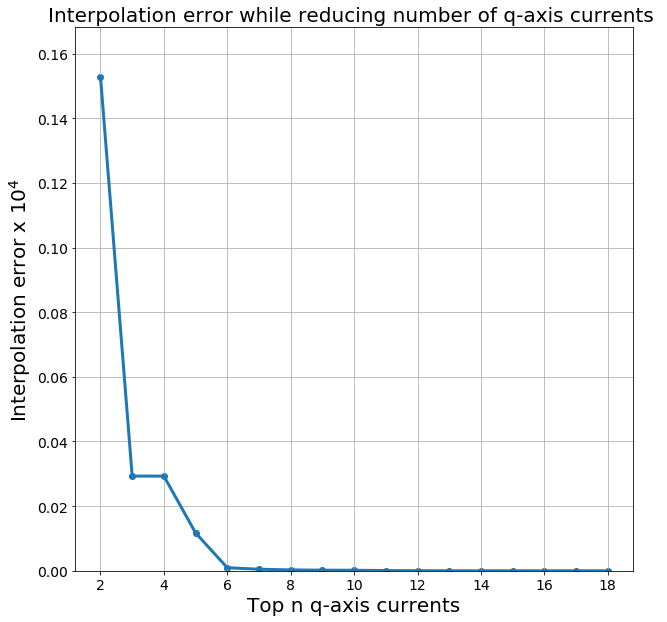

In [14]:

X = np.copy(np.transpose(Flux))

top_n = range(2, len(ids))
errors = []
for n in top_n:
    top_n_Iq_currents = get_top_iqs_currents(n)
    top_n_Iq_currents_indices = [get_index(iqs, c) for c in top_n_Iq_currents]
    error = 0
    for curve in range(X.shape[0]):
        # baseline = y values obtained when interpolating with all ground truth points
        x = iqs 
        baseline = X[curve, :] 

        # interpolate with top_n_currents as basis 
        x_ = top_n_Iq_currents
        y_ = X[curve, top_n_Iq_currents_indices]
        tck_ = interpolate.splrep(x_, y_, k=1)
        y = interpolate.splev(x, tck_) 
        
        # error -- difference between baseline interp curve and current one
        error += np.sum((baseline - y)**2) /  baseline.shape[0]
    errors.append(error / X.shape[0])
            
error_readable = np.multiply(errors, 10 **2)
        
plt.figure(figsize=(10, 10))
plt.xlabel('Top n q-axis currents', fontsize = 20)
plt.ylabel('Interpolation error x $10^4$', fontsize = 20)
plt.ylim([0.1*min(error_readable), 1.1*max(error_readable)])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.locator_params(axis='x', nbins=len(top_n))
plt.scatter(top_n, error_readable)
plt.plot(top_n, error_readable, linewidth=3)
plt.grid()
plt.title('Interpolation error while reducing number of q-axis currents ', fontsize=20)
plt.show()


# [REDUCE CURVES]

## Compare the Splines obtained with differnet number of basis points

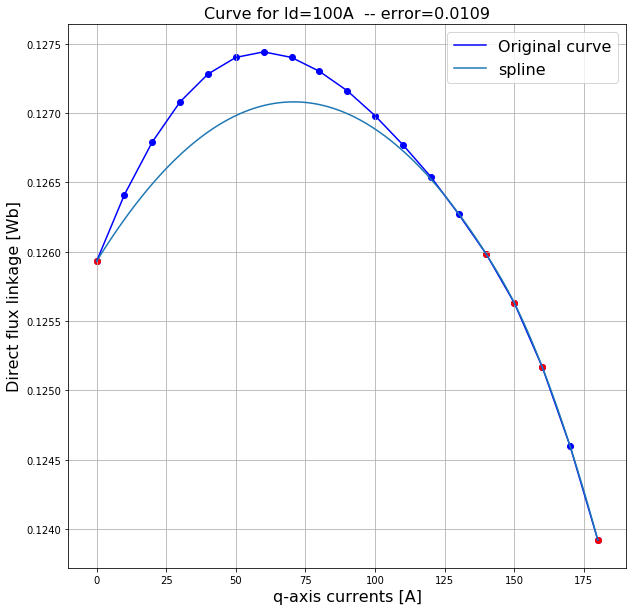

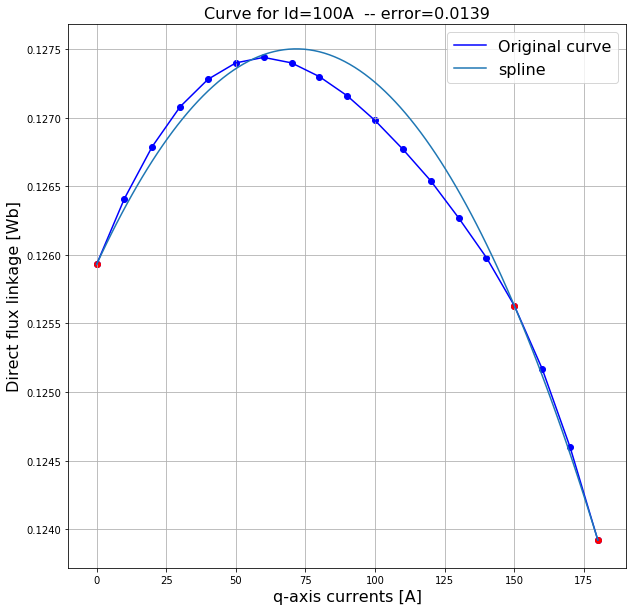

In [16]:

X = np.copy(np.transpose(Flux))

def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10**4) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

    
def compare_curve_with_interp(curve, n, top_n_function, title):
    top_n_iqs = top_n_function(n)
    top_n_iqs_indices = [get_index(iqs, c) for c in top_n_iqs]
    plt.figure(figsize=(10, 10))
    
    x = np.array(iqs)
    baseline = X[:,curve] 
      
    x_ = top_n_iqs
    y_ = X[top_n_iqs_indices,curve]
       
    splines = interpolate.splrep(x_,y_,s=0,k=2) 
    x_new = np.linspace(min(iqs), max(iqs),100)
    
    y_new = interpolate.splev(x_new, splines, der = 0) 
    
    
    plt.plot(x, baseline, c='b', label = 'Original curve')
    plt.scatter(x, baseline, c='b')
    plt.plot(x_new, y_new, label = 'spline')
   
    plt.scatter( x_,y_, c= 'r')
    error = sum_squared_error(baseline,y_new[len(iqs)])
  
       
    plt.grid()   
    plt.title('%s -- error=%.4f' % (title, error), fontsize=16)
    plt.legend(loc='best', fontsize = 16)
    plt.xlabel('q-axis currents [A]',fontsize = 16)
    plt.ylabel(yLabel,fontsize = 16)
#     plt.savefig('Output/PMASynRM_Machine/PMA_reduce_curves_spline_interp_Id=%d°_%d_pts.pdf' %(ids[curve], n))
    plt.show()
#     return error

# print('COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis')

curve = 10
n = 5
compare_curve_with_interp(curve, n, get_top_iqs_currents, 'Curve for Id=%dA ' % ids[curve])

curve = 10
n = 3
compare_curve_with_interp(curve, n, get_top_iqs_currents, 'Curve for Id=%dA ' % ids[curve])